In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchvision
import time

In [85]:
torch.manual_seed(42)
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])




In [86]:
# Check if GPU is available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


In [87]:
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


In [88]:
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

In [89]:
classes = ('airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

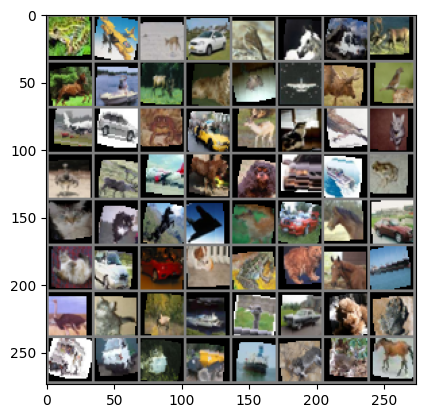

In [90]:
def imshow(img):
  img = img / 2 + 0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1,2,0)))
  plt.show()

dataiter = iter(trainloader)
images, label = next(dataiter)

imshow(torchvision.utils.make_grid(images))

In [91]:
import torch.nn as nn

class CIFARModel(nn.Module):
    def __init__(self):
        super(CIFARModel, self).__init__()
        self.CNNModel = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(256, 512, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(2, 2),

            nn.AdaptiveAvgPool2d(1),  # Global average pooling
            nn.Flatten(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 10),
        )
    def forward(self, x):
        return self.CNNModel(x)



In [92]:

model = CIFARModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [95]:

# Start tracking total time
start_time = time.time()

for epoch in range(10):
    epoch_start_time = time.time()  # Start time for the current epoch
    running_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()  # Zero the gradients
        outputs = model(inputs)  # Get model predictions
        loss = criterion(outputs, labels)  # Calculate the loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        running_loss += loss.item()

        # Print loss every 2000 batches
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
    scheduler.step()

    model.eval()
    correct = 0
    total = 0
    with torch.inference_mode():
      for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total

    # Track time per epoch
    epoch_elapsed_time = time.time() - epoch_start_time  # Calculate time for this epoch
    print(f"Epoch {epoch + 1} completed in {epoch_elapsed_time:.2f} seconds")

    print(f'Accuracy of the network on the 10000 test images: {accuracy}%')

# Total time taken for training
total_elapsed_time = time.time() - start_time  # Calculate total training time
print(f"Finished Training in {total_elapsed_time:.2f} seconds")


Epoch 1 completed in 34.66 seconds
Accuracy of the network on the 10000 test images: 82.47%
Epoch 2 completed in 35.87 seconds
Accuracy of the network on the 10000 test images: 82.57%
Epoch 3 completed in 34.46 seconds
Accuracy of the network on the 10000 test images: 82.67%
Epoch 4 completed in 35.03 seconds
Accuracy of the network on the 10000 test images: 82.65%
Epoch 5 completed in 34.85 seconds
Accuracy of the network on the 10000 test images: 82.8%
Epoch 6 completed in 35.11 seconds
Accuracy of the network on the 10000 test images: 82.78%
Epoch 7 completed in 34.43 seconds
Accuracy of the network on the 10000 test images: 82.85%
Epoch 8 completed in 36.08 seconds
Accuracy of the network on the 10000 test images: 82.84%
Epoch 9 completed in 35.35 seconds
Accuracy of the network on the 10000 test images: 82.9%
Epoch 10 completed in 34.93 seconds
Accuracy of the network on the 10000 test images: 82.89%
Finished Training in 350.77 seconds


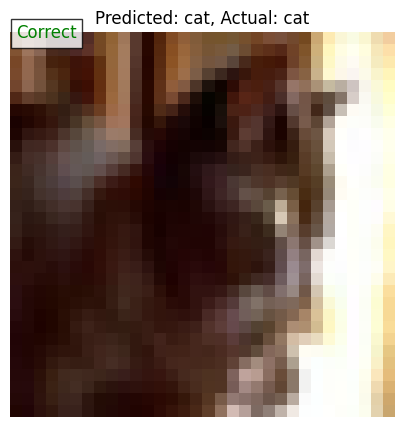

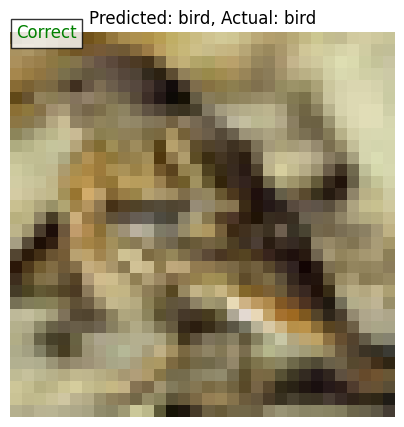

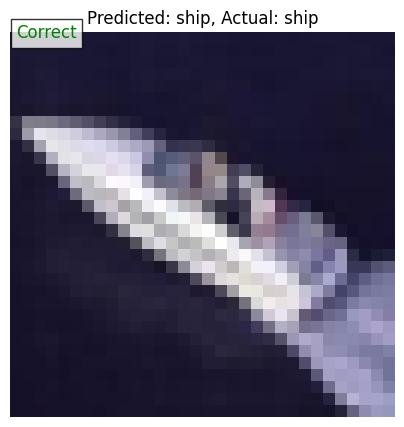

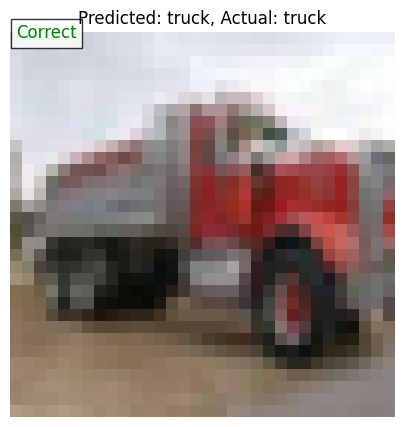

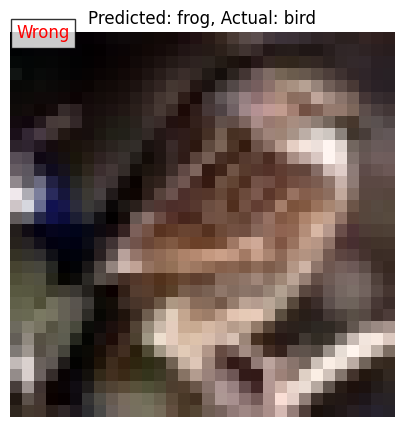

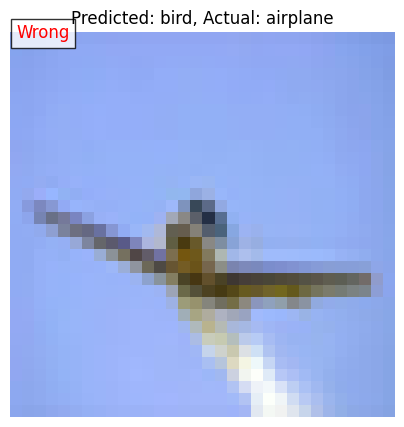

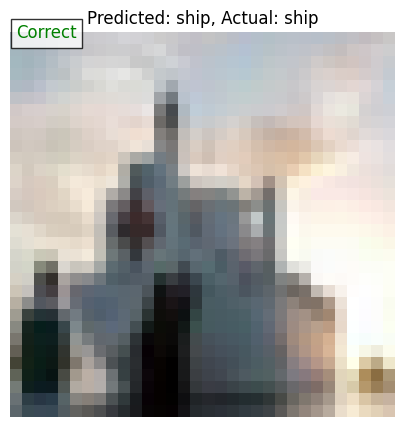

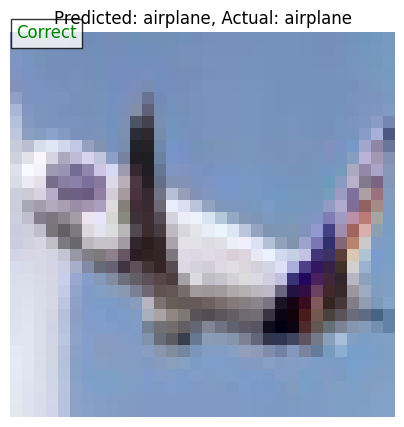

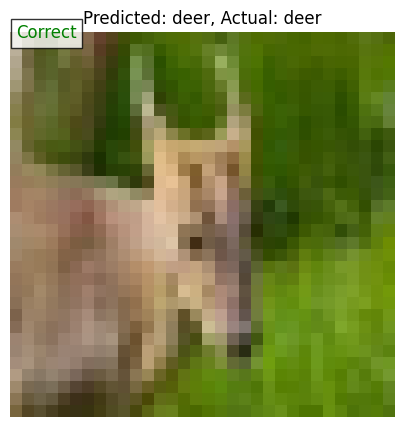

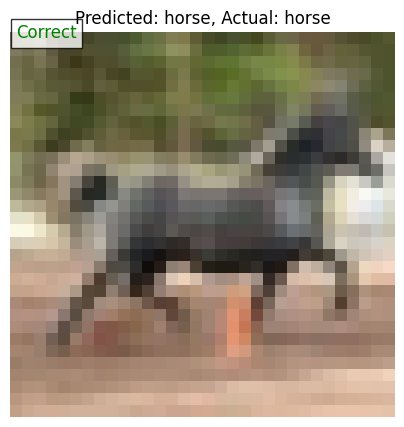

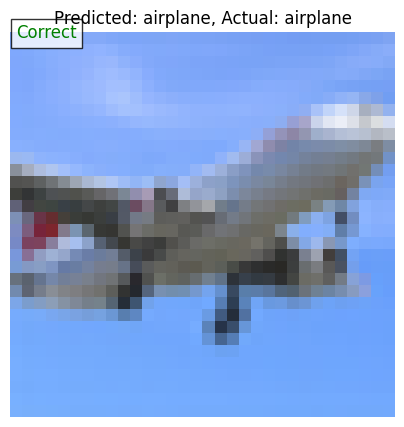

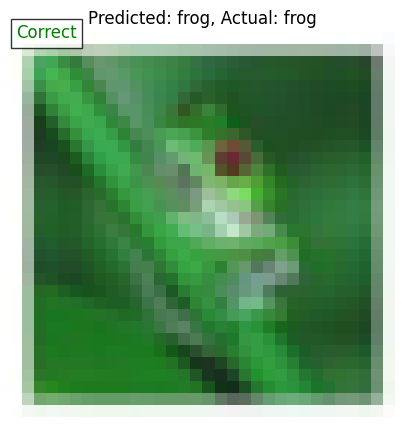

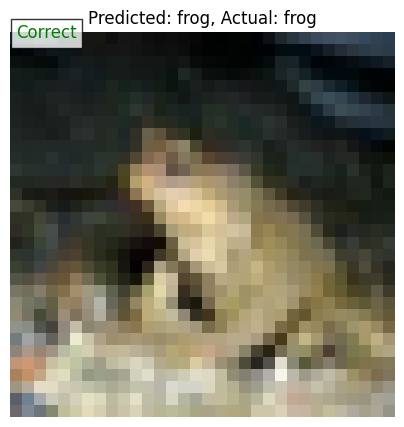

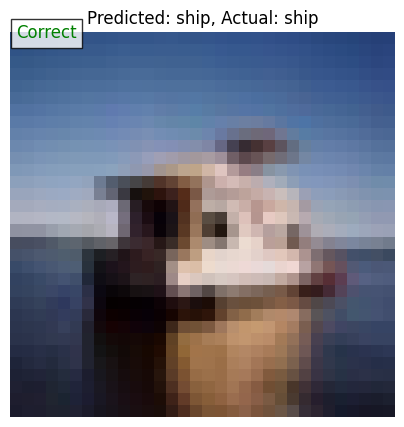

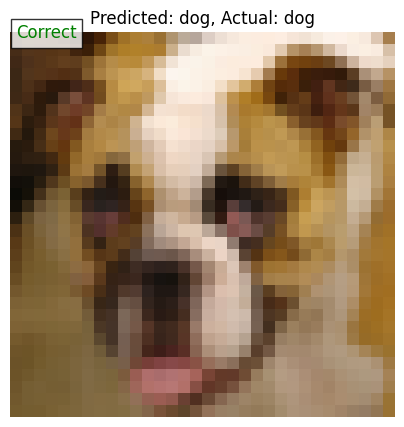

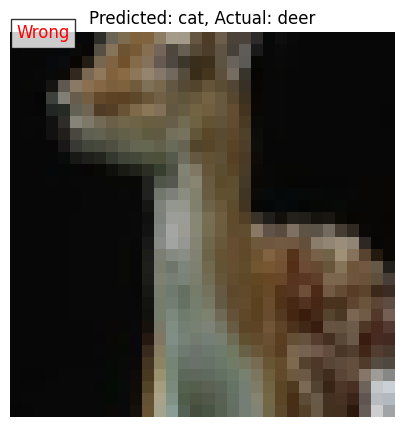

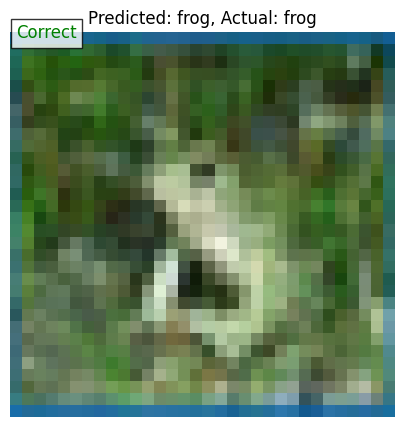

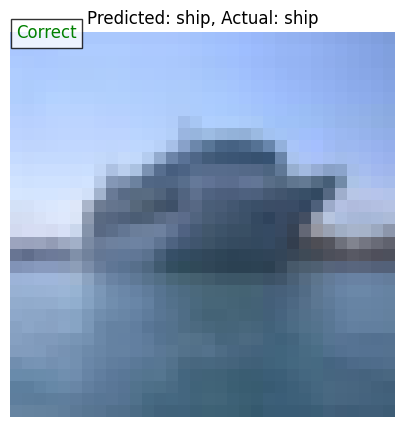

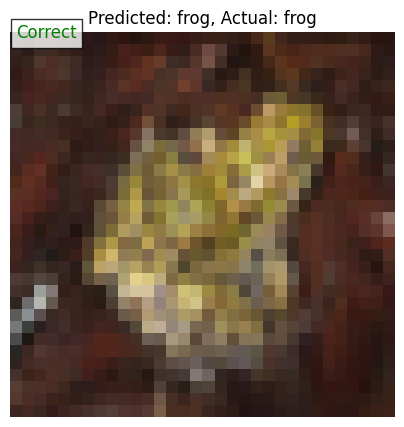

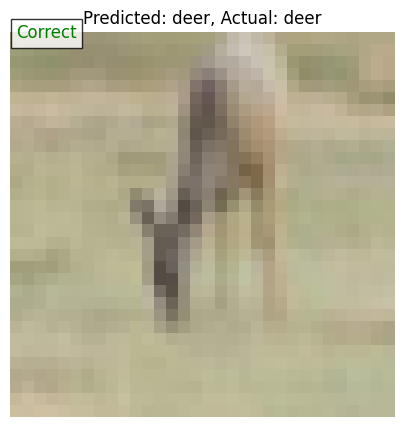

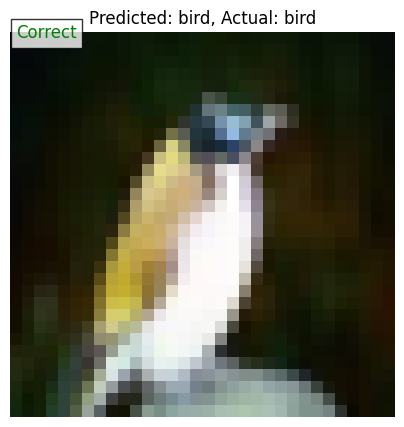

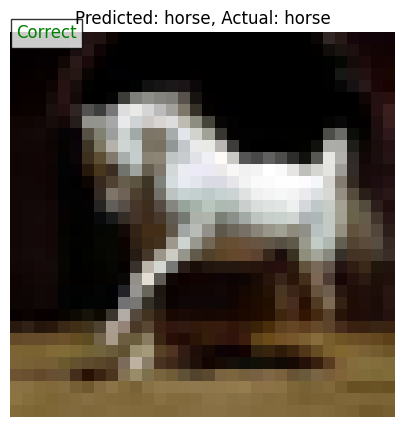

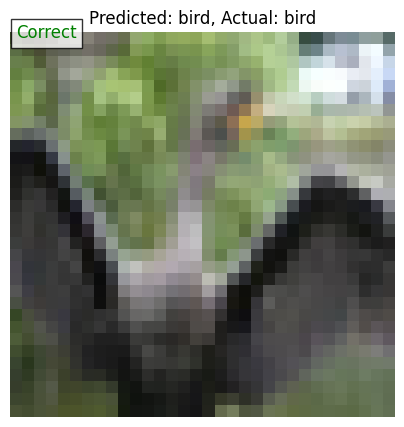

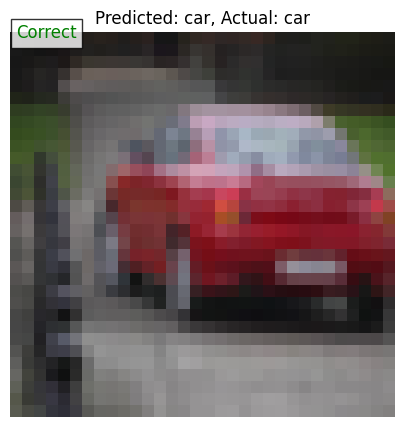

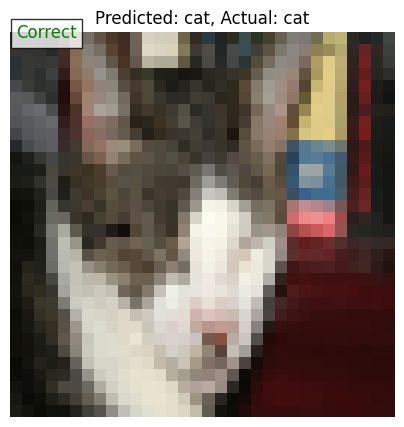

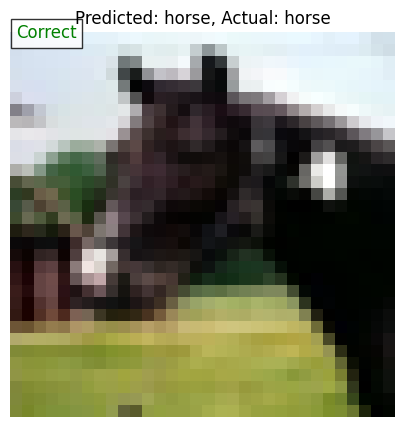

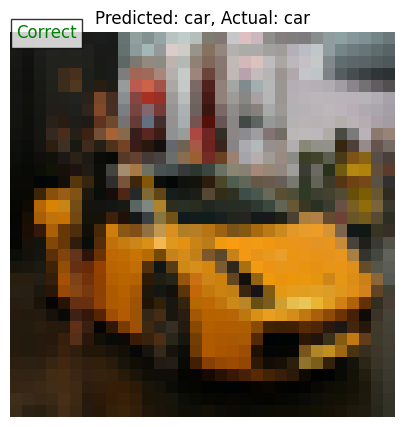

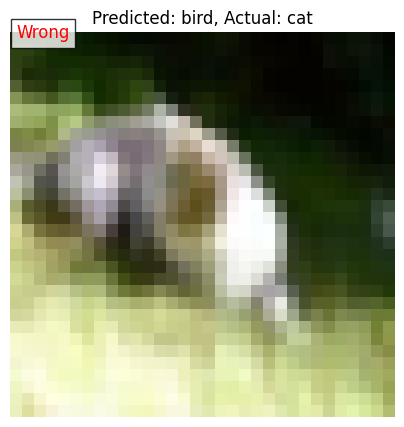

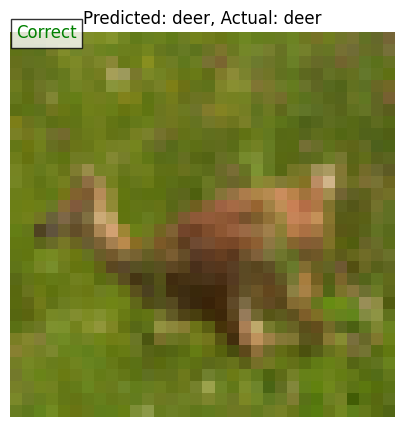

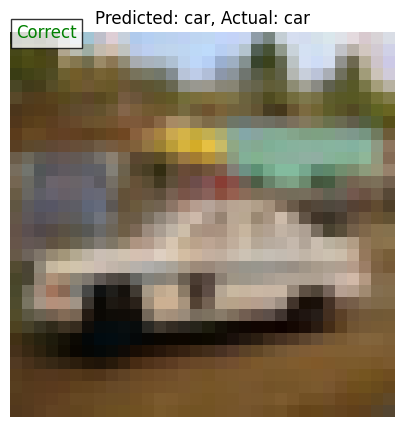

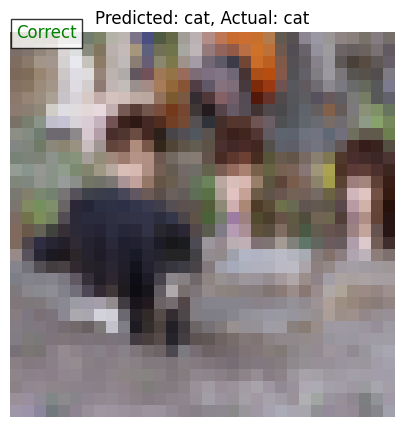

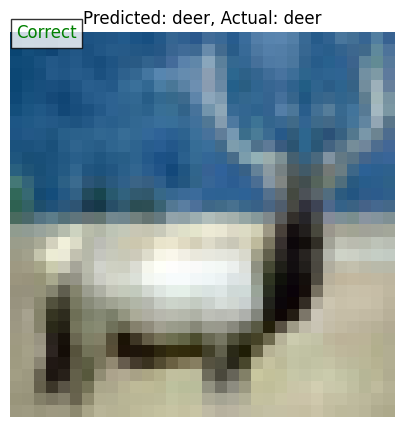

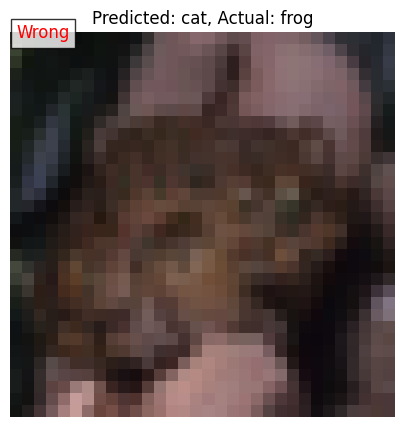

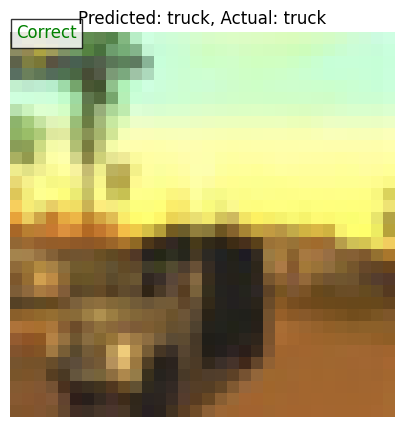

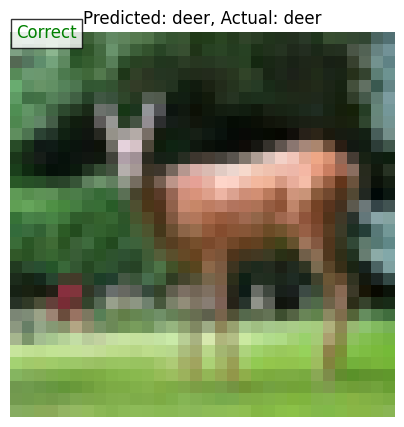

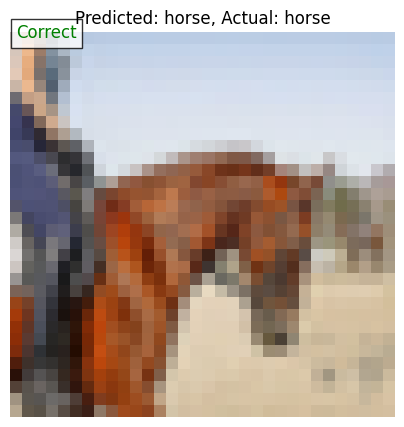

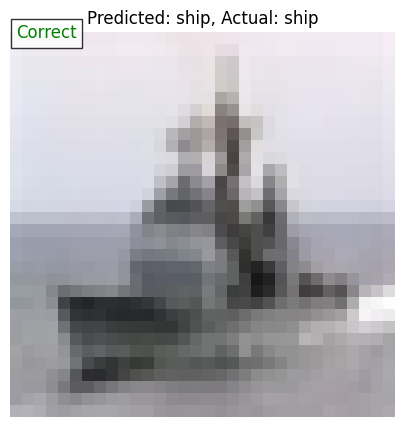

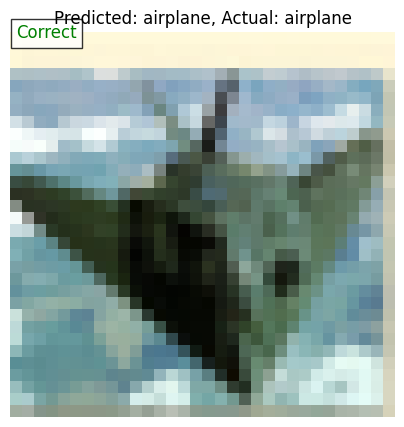

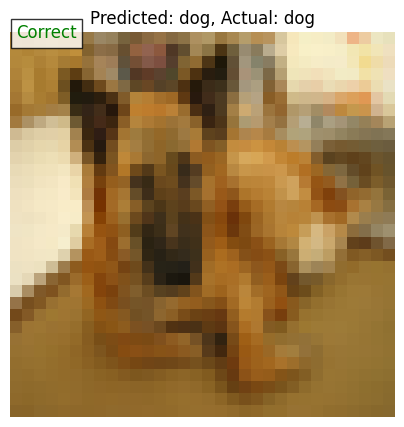

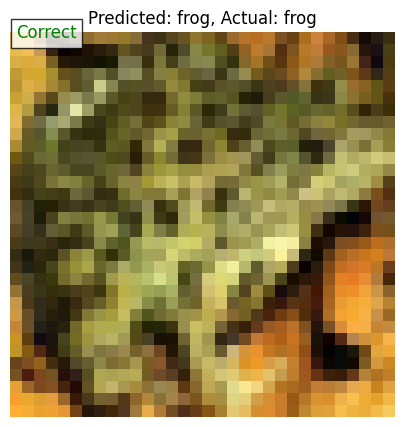

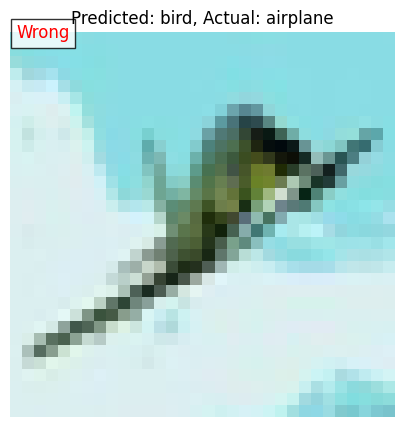

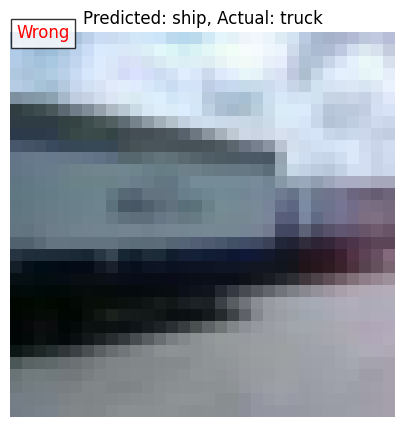

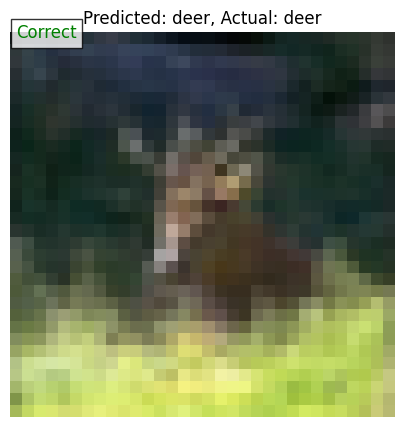

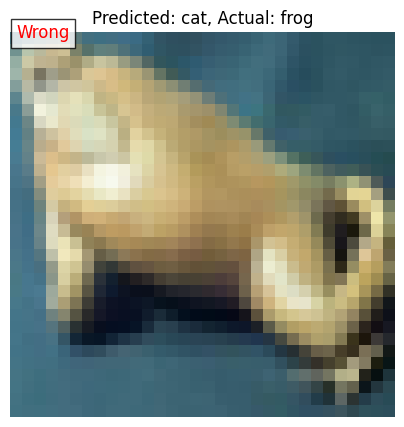

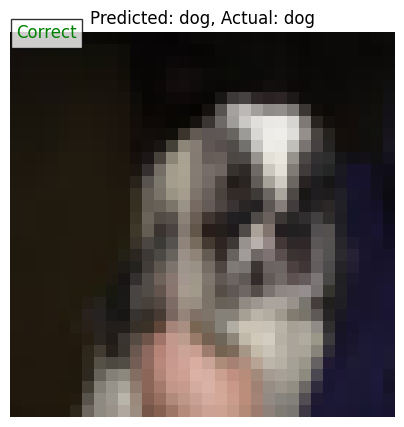

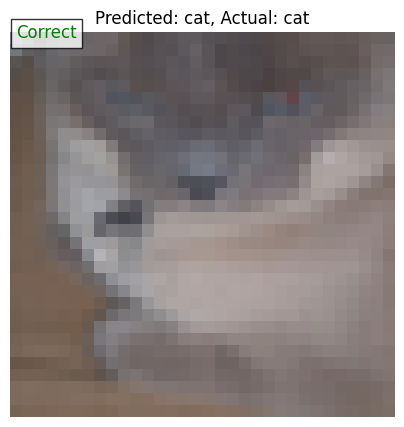

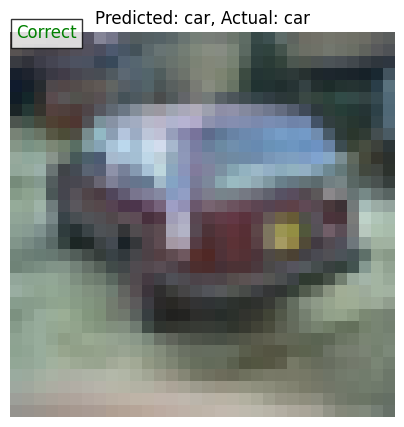

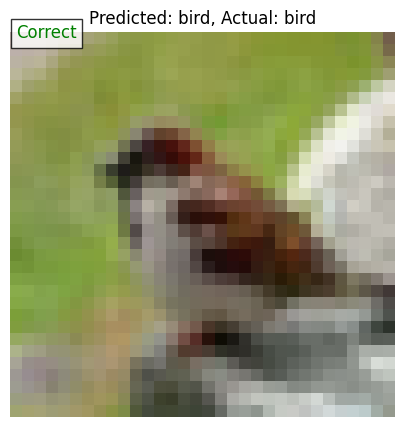

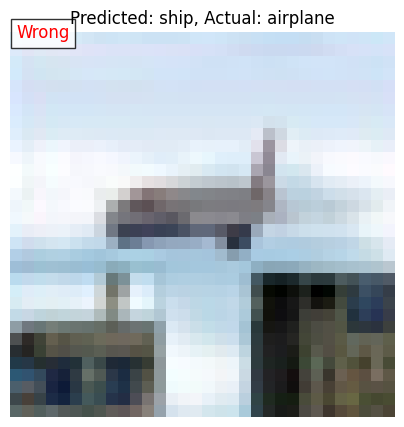

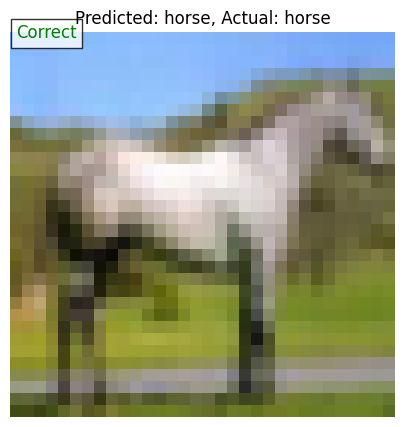

In [96]:

import random

# Assuming 'testset', 'model', and 'classes' are already defined and model is trained
# and 'device' is set to either "cuda" or "cpu"

# Select 50 random indices from the test set
random_indices = random.sample(range(len(testset)), 50)

model.eval()  # Set the model to evaluation mode

with torch.inference_mode():
    for i in random_indices:
        image, label = testset[i]
        image = image.unsqueeze(0).to(device)  # Add batch dimension and move to device
        output = model(image)
        _, predicted = torch.max(output, 1)

        # Create a larger figure for better clarity without changing resolution
        plt.figure(figsize=(5, 5))  # Adjust the figure size, don't resize the image

        # Display the image without interpolation
        # (No interpolation keeps the image sharp at 32x32 resolution)
        plt.imshow(np.transpose(image.cpu().squeeze(0).numpy(), (1, 2, 0)) / 2 + 0.5, interpolation='none')  # No interpolation

        plt.title(f"Predicted: {classes[predicted.item()]}, Actual: {classes[label]}")

        # Text indicating if the prediction was correct or not
        if predicted.item() == label:
            plt.text(0, 0, "Correct", color='green', fontsize=12, bbox=dict(facecolor='white', alpha=0.8))
        else:
            plt.text(0, 0, "Wrong", color='red', fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

        plt.axis('off')  # Hide axes for better visual clarity
        plt.show()
